In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from statistics import mean
from sklearn.naive_bayes import GaussianNB
import time
import ast
sns.set_theme()

In [10]:
stateful_df = pd.read_csv("Data/Prepared Data/stateful.csv")
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")
stateless_df = stateless_df.fillna("")

# Stateless Model - Reimplementation

Train Accuracy: 0.748806473765534
Test Accuracy: 0.749080512139881
Time elapsed: 1.09
Train Accuracy: 0.7527687947055726
Test Accuracy: 0.7332312040253034
Time elapsed: 0.98
Train Accuracy: 0.7464693637343608
Test Accuracy: 0.7583893503783626
Time elapsed: 1.03
Train Accuracy: 0.7462035858553343
Test Accuracy: 0.75945246364945
Time elapsed: 1.05
Train Accuracy: 0.750040031761282
Test Accuracy: 0.7441462738210007
Time elapsed: 1.00
Total time elapsed for predictions: 5.14


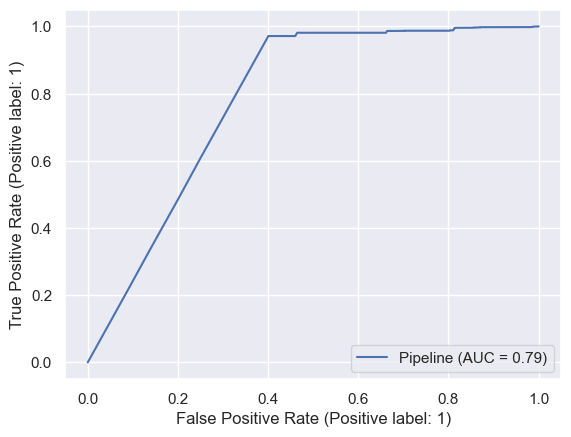

In [16]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]]]
y = stateless_df["attack"]
trained_pipes_gnb = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
      
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('GNB', GaussianNB())
    ])    
    pipe.fit(X_train, y_train)
    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateless += (end_fold - start_fold)
    
    trained_pipes_gnb.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

print(f"Total time elapsed for predictions: {(total_prediction_time_stateless):.2f}")
    
gnb_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    

In [17]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 5.143
Time to evaluate a single data point: 0.00000679


## Overall Results

In [18]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.971036,0.607262,0.747227,462858.00000
1,0.611370,0.971517,0.750472,294353.00000
accuracy,0.748860,0.748860,0.748860,0.74886
macro avg,0.791203,0.789390,0.748849,757211.00000
weighted avg,0.831222,0.748860,0.748488,757211.00000


## Light-attack

In [19]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.970289,0.619560,0.756239,60091.000000
1,0.645038,0.973291,0.775874,42683.000000
accuracy,0.766468,0.766468,0.766468,0.766468
macro avg,0.807663,0.796426,0.766056,102774.000000
weighted avg,0.835209,0.766468,0.764393,102774.000000


## Heavy-attack

In [20]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.938850,0.612117,0.741068,181694.000000
1,0.776197,0.971216,0.862824,251670.000000
accuracy,0.820659,0.820659,0.820659,0.820659
macro avg,0.857523,0.791667,0.801946,433364.000000
weighted avg,0.844391,0.820659,0.811776,433364.000000


In [21]:
stateless_df.Predictions.value_counts(normalize=True)

1    0.617729
0    0.382271
Name: Predictions, dtype: float64

# Stateful Model Reimplementation

In [22]:
stateful_df.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'original_index', 'data_type', 'attack',
       'origin'],
      dtype='object')

Train Accuracy: 0.6381555101962954
Test Accuracy: 0.6040708876213731
Time elapsed: 0.76
Train Accuracy: 0.6413126418801626
Test Accuracy: 0.6270769348161996
Time elapsed: 0.69
Train Accuracy: 0.6146916312164972
Test Accuracy: 0.6385418057648652
Time elapsed: 0.69
Train Accuracy: 0.6147440911085252
Test Accuracy: 0.6396863852272944
Time elapsed: 0.69
Train Accuracy: 0.6349840712691479
Test Accuracy: 0.6357566624062876
Time elapsed: 0.65
Total time elapsed for predictions: 3.47


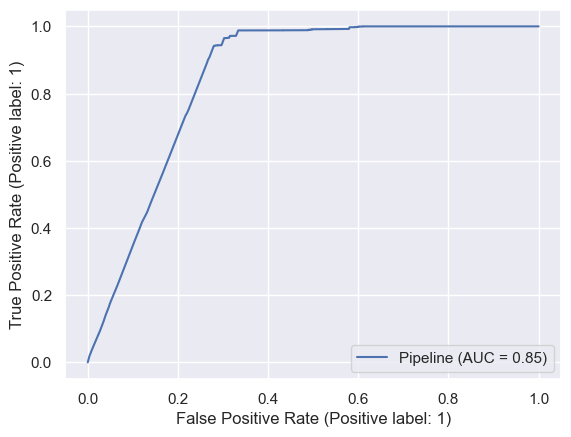

In [25]:
stateful_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
categorical_features = ["rr_type", "distinct_ip", "unique_country",
"unique_asn", "distinct_domains", "reverse_dns"]
X = stateful_df[[col for col in stateful_df.columns if col not in ["unique_ttl", "attack", "origin", "data_type", "original_index"]]]
y = stateful_df["attack"]
trained_pipes_gnb = []
time_t=[]
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateful=0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
     ('scaler', StandardScaler(), [col for col in X_train if col not in categorical_features])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('GNB', GaussianNB())
    ])    
    pipe.fit(X_train, y_train)
    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateful_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateful += (end_fold - start_fold)
    
    trained_pipes_gnb.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

print(f"Total time elapsed for predictions: {(total_prediction_time_stateful):.2f}")

gnb_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()   

In [26]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateful:.3f}")
single_datapoint_evaluation_time_stateful = total_prediction_time_stateful/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateful:.8f}")


Total prediction time for 757211 rows is 3.469
Time to evaluate a single data point: 0.00000458


## Overall Results

In [27]:
display(pd.DataFrame(classification_report(stateful_df["attack"], stateful_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.992404,0.459649,0.628293,178782.000000
1,0.461207,0.992451,0.629757,83323.000000
accuracy,0.629027,0.629027,0.629027,0.629027
macro avg,0.726806,0.726050,0.629025,262105.000000
weighted avg,0.823537,0.629027,0.628759,262105.000000


## Light Attack Results

In [28]:
temp = stateful_df[(stateful_df["origin"]=="light-attack")
                  | (stateful_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.992707,0.472286,0.640060,22768.000000
1,0.482803,0.993006,0.649713,11295.000000
accuracy,0.644952,0.644952,0.644952,0.644952
macro avg,0.737755,0.732646,0.644886,34063.000000
weighted avg,0.823627,0.644952,0.643261,34063.000000


## Heavy Attack Results

In [29]:
temp = stateful_df[(stateful_df["origin"]=="heavy-attack")
                  | (stateful_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.983432,0.473021,0.638790,69016.000000
1,0.662766,0.992364,0.794747,72028.000000
accuracy,0.738238,0.738238,0.738238,0.738238
macro avg,0.823099,0.732692,0.716769,141044.000000
weighted avg,0.819675,0.738238,0.718434,141044.000000


In [30]:
stateful_df.origin.value_counts()

only-benign     86998
heavy-attack    72028
heavy-benign    69016
light-benign    22768
light-attack    11295
Name: origin, dtype: int64

# Two STEP MODEL

In [31]:
WINDOW_SIZE=100
SUSPICIOUS_THRESHOLD = 0.4
ATTACK_THRESHOLD = 0.7


In [36]:
def two_step(stateless_df, stateful_df, is_light=True):
    estimated_time = 0
       
    if is_light:
        light_or_heavy_string = "light"
    else:
        light_or_heavy_string = "heavy"
        
    stateless_df_subset = stateless_df[stateless_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateless_df_subset["Final_two_step_prediction"] = stateless_df_subset["Predictions"]
    stateful_df_subset = stateful_df[stateful_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateful_df_subset["Final_two_step_prediction"] = stateful_df_subset["Predictions"] 
    stateful_df_subset['unique_ttl'] = stateful_df_subset['unique_ttl'].apply(ast.literal_eval)
    stateful_df_subset = stateful_df_subset.explode("unique_ttl")

    time_windows = []
    attack_ratios = []

    for i in range(0, stateless_df_subset.shape[0], WINDOW_SIZE):
        current_data = stateless_df_subset.iloc[i:i+WINDOW_SIZE]
        attack_ratio = (current_data[current_data["Predictions"]==1].shape[0]/current_data.shape[0])
        time_windows.append(i)
        attack_ratios.append(attack_ratio)
        estimated_time += (single_datapoint_evaluation_time_stateless * WINDOW_SIZE)
        if attack_ratio >= ATTACK_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
        elif attack_ratio < SUSPICIOUS_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0
        else:
            estimated_time += (single_datapoint_evaluation_time_stateful * WINDOW_SIZE)
            stateful_data_window = stateful_df_subset.iloc[i:i+WINDOW_SIZE]
            stateful_attack_ratio = (stateful_data_window[stateful_data_window["Predictions"]==1].shape[0]/stateful_data_window.shape[0])
            if stateful_attack_ratio >= 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
            elif stateful_attack_ratio < 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0

    plt.plot(time_windows, attack_ratios)
    plt.title("Stateless attack ratio over the 100-datapoint windows")
    plt.show()
    display(pd.DataFrame(classification_report(stateless_df_subset["attack"], stateless_df_subset["Final_two_step_prediction"], output_dict=True)).T)
    print("Total Estimated Time: ", estimated_time)

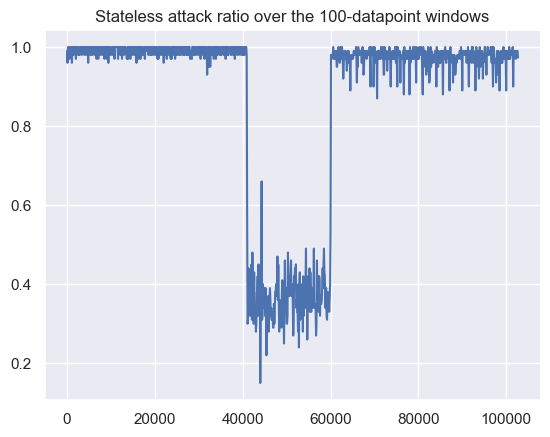

,precision,recall,f1-score,support
0,1.000000,0.227988,0.371319,60091.000000
1,0.479186,1.000000,0.647905,42683.000000
accuracy,0.548612,0.548612,0.548612,0.548612
macro avg,0.739593,0.613994,0.509612,102774.000000
weighted avg,0.783701,0.548612,0.486188,102774.000000


Total Estimated Time:  0.7238392025033041


In [37]:
two_step(stateless_df, stateful_df, is_light=True)

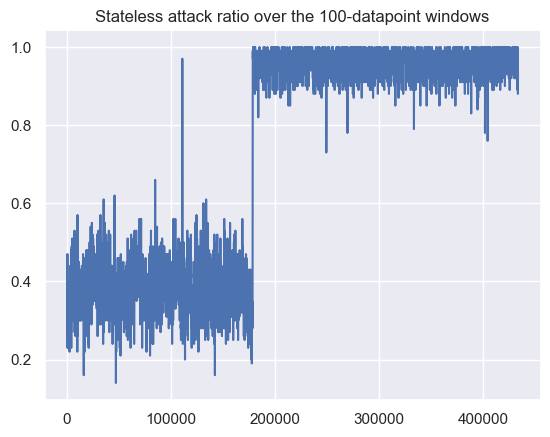

,precision,recall,f1-score,support
0,1.000000,0.718791,0.836391,181694.000000
1,0.831241,1.000000,0.907845,251670.000000
accuracy,0.882099,0.882099,0.882099,0.882099
macro avg,0.915621,0.859395,0.872118,433364.000000
weighted avg,0.901996,0.882099,0.877887,433364.000000


Total Estimated Time:  3.246351943228402


In [38]:
two_step(stateless_df, stateful_df, is_light=False)